# Ebola Model

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import active_subspaces as ac

## 1. Set up the Model

In [2]:
#Liberian lower and upper parameter bounds
lb_L = np.array([.1, .1, .05, .41, .0276, .081, .25, .0833])
ub_L = np.array([.4, .4, .2, 1, .1702, .21, .5, .7])
#Sierra Leone bounds
lb_S = np.array([.1, .1, .05, .41, .0275, .1236, .25, .0833])
ub_S = np.array([.4, .4, .2, 1, .1569, .384, .5, .7])

#basic reproduction number
def R0(x):
    b1 = x[:,0]; b2 = x[:,1]; b3 = x[:,2]; r1 = x[:,3]
    g1 = x[:,4]; g2 = x[:,5]; om = x[:,6]; p = x[:,7]
    
    return (b1 + b2*r1*g1/om + b3*p/g2)/(g1 + p)

#reproduction number gradient with respect to UNnormalized parameters
def R0_grad(x):
    b1 = x[:,0]; b2 = x[:,1]; b3 = x[:,2]; r1 = x[:,3]
    g1 = x[:,4]; g2 = x[:,5]; om = x[:,6]; p = x[:,7]
    
    dRdb1 = (1./(g1 + p))[:,None]
    dRdb2 = (r1*g1/om/(g1 + p))[:,None]
    dRdb3 = (p/g2/(g1 + p))[:,None]
    dRdr1 = (b2*g1/om/(g1 + p))[:,None]
    dRdg1 = (b2*r1/om/(g1 + p) - R0(x)/(g1 + p))[:,None]
    dRdg2 = (-b3*p/g2**2/(g1 + p))[:,None]
    dRdom = (-b2*r1*g1/om**2/(g1 + p))[:,None]
    dRdp = (b3/g2/(g1 + p) - R0(x)/(g1 + p))[:,None]
    
    return np.hstack((dRdb1, dRdb2, dRdb3, dRdr1, dRdg1, dRdg2, dRdom, dRdp))

#Integrand for C
def subspace_integrand(df):
    df = df.reshape((8, 1))
    return df.dot(df.T)*2**-8

## 2. Compute the gradients

In [3]:
#gauss-legendre quadrature points/weights
xx, w = ac.utils.quadrature.gauss_legendre([8, 8, 8, 8, 8, 8, 8, 8])

#un-normalized inputs for Liberia (S) and Sierra Leone (S)
x_L = lb_L + (ub_L - lb_L)/2.*(xx + 1)
x_S = lb_S + (ub_S - lb_S)/2.*(xx + 1)

#output and gradient values
R_L = R0(x_L)
dR_L = R0_grad(x_L)
R_S = R0(x_S)
dR_S = R0_grad(x_S)

#Gradients with respect to noramlized inputs according to the chain rule
dR_L *= (ub_L - lb_L)/2.
dR_S *= (ub_S - lb_S)/2.

#Compute C for Liberia
integrands = []
for i in range(dR_L.shape[0]):
    integrands.append(subspace_integrand(dR_L[i])*w[i])
integrands = np.array(integrands)
C_L = integrands.sum(axis=0)

#Compute C for Sierra Leone
integrands = []
for i in range(dR_S.shape[0]):
    integrands.append(subspace_integrand(dR_S[i])*w[i])
integrands = np.array(integrands)
C_S = integrands.sum(axis=0)

## 3. DerSHAP - Sensitivity Analysis

In [6]:
def DerSHAP_Ebola(C):
    """
    Input: 
         df: M-by-d matrix, that contains estimated partial derivatives( in our case, approximated by finite difference method)
    Output: 
        norm_shap:  normalized DerSHAP values
    Parameters:
        C: d-by-d matrix, this is the gradient matrix
        shap: d-by-1 array, this is the DerSHAP values array
        norm_shap: d-by 1 array, this is the normalized DerSHAP values
    """
    C = abs(C)
    shap = np.zeros(len(C))
    for ii in range(len(C)):
        shap[ii] = 0.5*C[ii,ii]
        temp = 0
        for jj in range(len(C[0])):
            temp = 0.5 * C[ii,jj]
        shap[ii] += temp
    norm_shap = [shap[ii]/sum(shap) for ii in range(len(shap))]
    return norm_shap

### 3.1 DerSHAP for Liberia

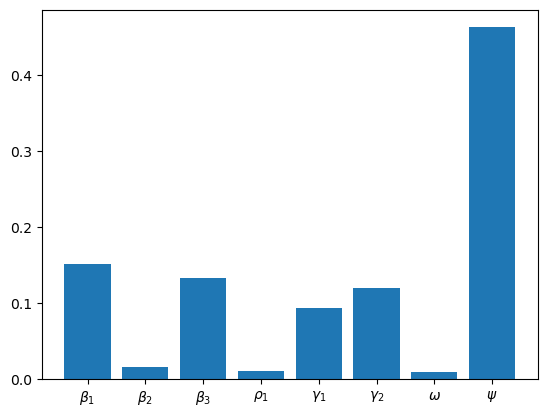

In [9]:
norm_shap = DerSHAP_Ebola(C_L)
#labels for plots
in_labels = [r'$\beta_1$', r'$\beta_2$', r'$\beta_3$', r'$\rho_1$', r'$\gamma_1$',\
            r'$\gamma_2$', r'$\omega$', r'$\psi$']
plt.bar(in_labels, norm_shap)
plt.savefig("Liberia.pdf")

### 3.2 DerSHAP for Sierra Leone

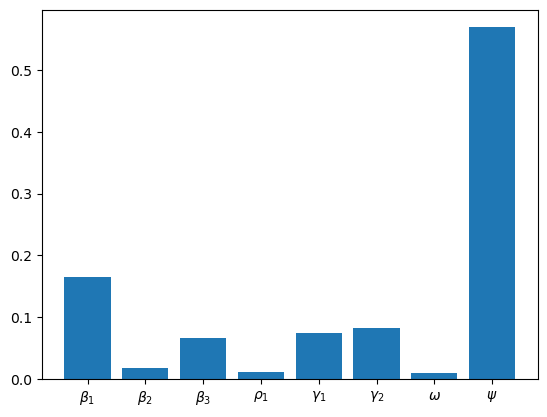

In [10]:
norm_shap = DerSHAP_Ebola(C_S)
#labels for plots
in_labels = [r'$\beta_1$', r'$\beta_2$', r'$\beta_3$', r'$\rho_1$', r'$\gamma_1$',\
            r'$\gamma_2$', r'$\omega$', r'$\psi$']
plt.bar(in_labels, norm_shap)
plt.savefig("Sierra.pdf")